In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges, to_dense_adj, to_networkx
import sys
#add path to utils
sys.path.append('../../')
from utils import GraphDatasetV3, outputs_to_networkx_mst, _gt_tree_from_batch, _pred_tree_from_logits
from networks.graph_vae import GRAPH_VAE
from networks.graph_vae_v3 import GRAPH_VAE_V3
# from networks.gae import GRAPH_VAE_V3
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.utils.data import random_split
import argparse
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from torch_geometric.utils import negative_sampling
import itertools
import matplotlib.colors as mcolors
from tqdm import tqdm

/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/

In [2]:
dataset = GraphDatasetV3(root='../../../data/sub20/graphs')

In [3]:
# Define the parameters
params = {
    'distribution_std': 0.1,
    'variational_beta': 0.05,
    'capacity': 256,
    'dec_layers': 4,
    'edge_layers': 4,
    'ign_layers': 2,
    'enc_layers': 3,
    "edge_pos_weight": 1,   # you already use this
    "edge_neg_weight": 1,    # NEW: >1 penalizes negatives → higher precision
    "edge_loss_lambda": 0.005,
}

In [4]:
device = torch.device('cpu')
input_dim = 5 #dataset.num_features
latent_dim = 128
model = GRAPH_VAE_V3(input_dim=input_dim, latent_dim=latent_dim, params=params, template=dataset.template, ).to(device)
# Load weights
model.load_state_dict(torch.load(f"../../networks/weights/GRAPH_VAE_V3_UNDIR_latent=128_lr=0.0005_epochs=2000_variational_beta=0.05_capacity=256_dec_layers=4_enc_layers=3_ign_layers=2_edge_layers=4_best.pt")["model_state_dict"])

/home/lucas/graph_scenarios/src/experiments/latent_space_analysis/../../networks/graph_vae_v3.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("undir_src", torch.tensor(u_src, dtype=torch.long))
/home/lucas/graph_scenarios/src/experiments/latent_space_analysis/../../networks/graph_vae_v3.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("undir_dst", torch.tensor(u_dst, dtype=torch.long))
/home/lucas/graph_scenarios/src/experiments/latent_space_analysis/../../networks/graph_vae_v3.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True),

<All keys matched successfully>

In [5]:
# Create the DataLoader
loader = DataLoader(dataset, batch_size=1, shuffle=True)
# Split the dataset into training, validation, and test sets
print("Splitting the dataset")
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"Train size: {train_size}, Val size: {val_size}")

# Seed split
SEED = 12345
g_split = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g_split)
device = torch.device('cuda')
model.to(device)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)


Splitting the dataset
Train size: 39300, Val size: 4912


In [6]:
def _micro_f1_on_edges(G_pred: nx.DiGraph, G_true: nx.DiGraph):
    """Micro-precision/recall/F1 over directed edges."""
    e_pred = set(G_pred.edges())
    e_true = set(G_true.edges())
    tp = len(e_pred & e_true)
    fp = len(e_pred - e_true)
    fn = len(e_true - e_pred)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1   = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0
    return tp, fp, fn, prec, rec, f1

@torch.no_grad()
def tune_tau_edge_for_tree_f1(
    model,
    loader,
    template,
    device,
    taus=None,                  # list of thresholds in prob space
    cache_outputs: bool = True, # cache model outputs to avoid recomputation per τ
    decode_fn=None,             # tree decoder (MST variant)
):
    """
    Grid-search τ_edge to maximize micro-F1 on reconstructed directed trees.

    decode_fn: callable(edge_logits_u, ign_logits, template, tau_edge) -> (G_pred, ign)
               defaults to _pred_tree_from_logits (weighted MST).

    Returns:
        best_tau: float
        metrics_by_tau: dict[tau] -> {"precision","recall","f1","tp","fp","fn","support_true","support_pred"}
    """
    model.eval()
    E_u = template.E_u
    N   = template.Nmax

    if decode_fn is None:
        decode_fn = _pred_tree_from_logits

    if taus is None:
        # Reasonable sweep in probability space
        taus = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45,
                0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

    # ---- cache pass ----
    cached = []
    for batch in tqdm(loader):
        batch = batch.to(device)
        (edge_logits_u_B, ign_logits_B), mu, logvar = model(batch.x, batch.edge_index_enc, batch)
        # Shapes: [B, E_u], [B, N]
        B = edge_logits_u_B.size(0)

        # Pre-compute GT trees once
        for b in range(B):
            G_true = _gt_tree_from_batch(batch, template, b)
            cached.append({
                "edge_logits_u": edge_logits_u_B[b].detach().cpu(),  # [E_u]
                "ign_logits":    ign_logits_B[b].detach().cpu(),     # [N]
                "G_true":        G_true,
            })

    # ---- sweep taus ----
    best_tau = None
    best_f1  = -1.0
    metrics_by_tau = {}

    for tau in tqdm(taus):
        TP = FP = FN = 0
        for item in cached:
            G_pred, ign = decode_fn(item["edge_logits_u"], item["ign_logits"], template, tau_edge=tau)
            tp, fp, fn, prec, rec, f1 = _micro_f1_on_edges(G_pred, item["G_true"])
            TP += tp; FP += fp; FN += fn

        prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        rec  = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1   = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

        metrics_by_tau[tau] = {
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "tp": TP, "fp": FP, "fn": FN,
            "support_true": TP + FN,
            "support_pred": TP + FP,
        }

        if f1 > best_f1:
            best_f1, best_tau = f1, tau

    return best_tau, metrics_by_tau


In [86]:
best_tau, metrics_by_tau = tune_tau_edge_for_tree_f1(model, val_loader, dataset.template, device)

100%|██████████| 18/18 [03:49<00:00, 12.72s/it]


In [87]:
best_tau

0.1

In [88]:
metrics_by_tau

{0.05: {'precision': 0.8865262477815188,
  'recall': 0.8943421956168359,
  'f1': 0.8904170702243475,
  'tp': 922099,
  'fp': 118027,
  'fn': 108937,
  'support_true': 1031036,
  'support_pred': 1040126},
 0.1: {'precision': 0.8897341417594774,
  'recall': 0.8925275160130199,
  'f1': 0.8911286398306499,
  'tp': 920228,
  'fp': 114045,
  'fn': 110808,
  'support_true': 1031036,
  'support_pred': 1034273},
 0.15: {'precision': 0.8916900811008546,
  'recall': 0.8889398624296339,
  'f1': 0.8903128478812876,
  'tp': 916529,
  'fp': 111327,
  'fn': 114507,
  'support_true': 1031036,
  'support_pred': 1027856},
 0.2: {'precision': 0.8933321450117918,
  'recall': 0.8846781295706454,
  'f1': 0.8889840766752237,
  'tp': 912135,
  'fp': 108913,
  'fn': 118901,
  'support_true': 1031036,
  'support_pred': 1021048},
 0.25: {'precision': 0.8950295580675875,
  'recall': 0.8779829220318204,
  'f1': 0.8864242925723462,
  'tp': 905232,
  'fp': 106167,
  'fn': 125804,
  'support_true': 1031036,
  'support

In [7]:
def plot_tau_edge_curve(metrics_by_tau, save_path=None, show=False, title="τ_edge sweep (MST tree F1)"):
    """
    Plot Precision/Recall/F1 vs τ_edge given the dict from tune_tau_edge_for_tree_f1.
    """
    taus = sorted(metrics_by_tau.keys())
    f1   = [metrics_by_tau[t]["f1"]        for t in taus]
    prec = [metrics_by_tau[t]["precision"] for t in taus]
    rec  = [metrics_by_tau[t]["recall"]    for t in taus]

    plt.figure()
    plt.plot(taus, f1,   marker="o", label="F1")
    plt.plot(taus, prec, marker="o", label="Precision")
    plt.plot(taus, rec,  marker="o", label="Recall")
    plt.xlabel("τ_edge (probability threshold)")
    plt.ylabel("Score")
    plt.title(title)
    plt.ylim(0.0, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    if show:
        plt.show()
    plt.close()

In [98]:
plot_tau_edge_curve(metrics_by_tau, save_path="./Threshold_curve.png")

In [23]:
model.eval()
device = torch.device('cpu')
model.to(device)
picked_G = None
for batch in loader:
    
    batch = batch.to(device)
    # use edge_index_enc if present; else fall back to edge_index
    edge_index_enc = getattr(batch, "edge_index_enc", batch.edge_index)
    output, mu, logvar = model(batch.x, edge_index_enc, batch.batch)
    edge_logits, ign_logits = output

    # reconstruct NX graph from the model outputs
    G = _pred_tree_from_logits(edge_logits_u=edge_logits.squeeze(0), ign_logits=ign_logits.squeeze(0), template=dataset.template, tau_edge=0.1)

    # replicate your “pick a mid-sized graph” filter (50 < #nodes < 60)
    if 10 < G.number_of_nodes() < 20:
        picked_G = G
        break


/tmp/ipykernel_4164/1766917709.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


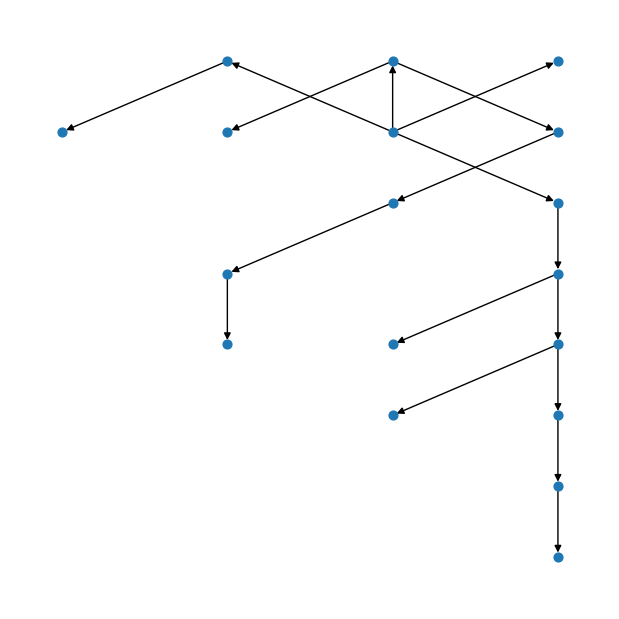

In [24]:
if picked_G is None:
    # fall back to the last one
    picked_G = G

# position nodes by (col,row) or normalized positions
W = dataset.template.W
pos = {n: (n % W, -(n // W)) for n in picked_G.nodes}  # x=col, y=-row (flip y for nicer top-down look)
plt.figure(figsize=(6,6))
nx.draw(
    picked_G, pos,
    node_size=40,
    arrows=True,
    with_labels=False,
    cmap="viridis",
)
plt.tight_layout()
plt.show()

In [25]:
# check number of connected components, turn into undirected graph
picked_G = G.to_undirected()
print(nx.number_connected_components(picked_G))


1


In [26]:
# Ground-truth directed tree
G_real = _gt_tree_from_batch(batch, template=model.template, b = 0)

# Compare edges
edges_pred = set(picked_G.edges())
edges_real = set(G_real.edges())
unique_to_G = edges_pred - edges_real
unique_to_G_real = edges_real - edges_pred


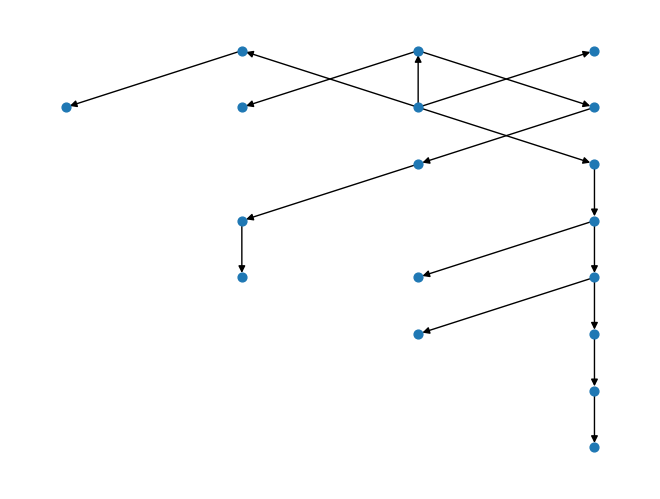

In [27]:
# draw graph
# drop unconnected nodes
G_real.remove_nodes_from(list(nx.isolates(G_real)))
pos = {n: (n % W, -(n // W)) for n in G_real.nodes}  # x=col, y=-row (flip y for nicer top-down look)

# draw with labels
nx.draw(G_real, pos,
    node_size=40,
    arrows=True,
    with_labels=False,
    cmap="viridis",)
plt.show()

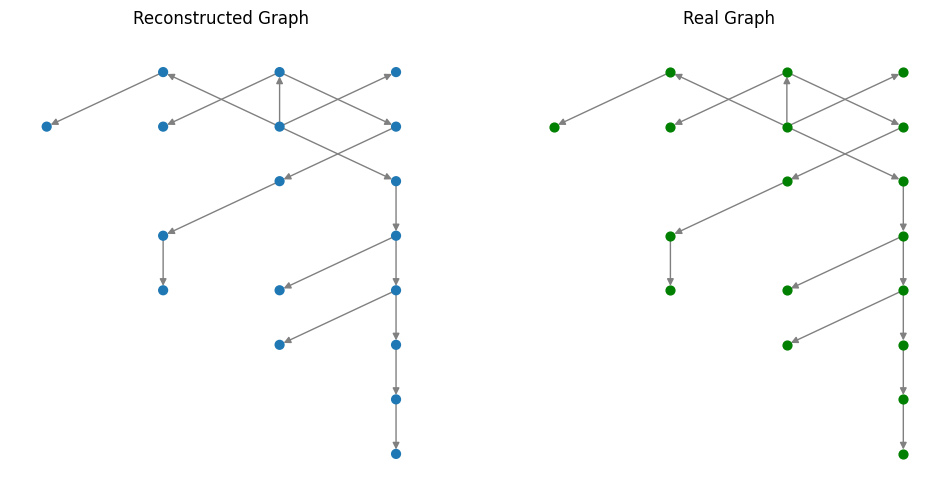

In [28]:
# Find connected components in the reconstructed graph
components = list(nx.weakly_connected_components(G))
colors = itertools.cycle(['#1f78b4', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow'])

# Assign a color to each node based on its component
node_colors = {}
for component, color in zip(components, colors):
    for node in component:
        node_colors[node] = color

# Plotting the graphs side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the reconstructed graph
pos = {n: (n % W, -(n // W)) for n in G.nodes} 
nx.draw(G, pos, ax=axes[0], with_labels=False, node_color=[node_colors[node] for node in G.nodes()], edge_color='gray', node_size=40)
if unique_to_G:
    nx.draw_networkx_edges(G, pos, edgelist=unique_to_G, edge_color='red', ax=axes[0])
axes[0].set_title('Reconstructed Graph')

# Plot the real graph
pos_real = {n: (n % W, -(n // W)) for n in G_real.nodes} 
G_real.remove_nodes_from(list(nx.isolates(G_real)))
nx.draw(G_real, pos_real, ax=axes[1], with_labels=False, node_color='green', edge_color='gray', node_size=40,)
if unique_to_G_real:
    nx.draw_networkx_edges(G_real, pos_real, edgelist=unique_to_G_real, edge_color='red', ax=axes[1])
axes[1].set_title('Real Graph')

plt.show()

In [29]:
# Collect posterior samples
model.train()
_, mu, logvar = model(batch.x, edge_index_enc, batch.batch)
edge_logits, ign_logits = output
G = _pred_tree_from_logits(edge_logits_u=edge_logits.squeeze(0), ign_logits=ign_logits.squeeze(0), template=dataset.template, tau_edge=0.1)
num_samples = 3
samples = []
for _ in range(num_samples):
    mu_ = model.latent_sample(mu, logvar)
    edge_logits, ign_logits = model.decode(mu_)
    Gs = _pred_tree_from_logits(
        edge_logits_u=edge_logits.squeeze(0),
        ign_logits=ign_logits.squeeze(0),
        template=dataset.template, 
        tau_edge=0.1
    )
    samples.append(Gs)

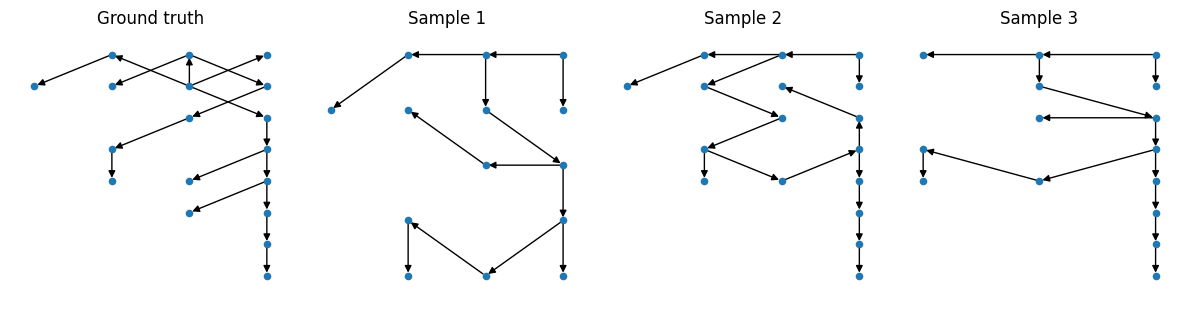

In [30]:
# ---- Plot: GT + samples ----
cols = num_samples + 1
plt.figure(figsize=(3.0*cols, 3.2))
# GT
plt.subplot(1, cols, 1)
nx.draw(G, pos = {n: (n % W, -(n // W)) for n in G.nodes} , node_size=20, arrows=True, with_labels=False)
plt.title("Ground truth")

# Samples
for i, Gi in enumerate(samples, start=2):
    plt.subplot(1, cols, i)
    nx.draw(Gi, pos = {n: (n % W, -(n // W)) for n in Gi.nodes} , node_size=20, arrows=True, with_labels=False)
    plt.title(f"Sample {i-1}")
plt.tight_layout()
plt.show()


In [42]:
import random
loader_ = DataLoader(dataset, batch_size=2, shuffle=True)
@torch.no_grad()
def interpolate_two_graphs_and_plot(
    model,
    loader,
    template,
    n_steps: int = 6,          # number of interpolation snapshots between endpoints
    tau_edge: float = 0.0,     # edge cutoff before MST (0.0 = let MST handle)
    sample: bool = True,       # sample z from posterior (True) or use means (False)
    device=None,
):
    """Pick two random graphs, interpolate in latent space, decode, and plot."""
    device = device or (next(model.parameters()).device if any(True for _ in model.parameters()) else torch.device("cpu"))
    model.eval().to(device)

    # --- get a batch with at least 2 graphs
    batch = None
    for b in loader:
        if b.num_graphs >= 2:
            batch = b
            break
    if batch is None:
        raise RuntimeError("Need a loader that yields batches with at least 2 graphs.")

    batch = batch.to(device)
    B = batch.num_graphs
    # pick two distinct indices
    b1, b2 = random.sample(range(B), 2)

    # encode once
    x = batch.x
    edge_index_enc = getattr(batch, "edge_index_enc", batch.edge_index)
    mu, logvar = model.encode(x, edge_index_enc, batch.batch)  # [B, z]
    std = torch.exp(0.5 * logvar)

    z1 = mu[b1:b1+1]
    z2 = mu[b2:b2+1]

    # ground-truth directed trees for endpoints
    G1_true = _gt_tree_from_batch(batch, template, b=b1)
    G2_true = _gt_tree_from_batch(batch, template, b=b2)

    # latents along the line
    ts = torch.linspace(0., 1., steps=n_steps, device=device)
    interp_graphs = []
    for t in ts:
        zt = torch.lerp(z1, z2, float(t))      # [1, z]
        edge_logits_u, ign_logits = model.decode(zt)  # [1, E_u], [1, N]
        Gt = _pred_tree_from_logits(
            edge_logits_u=edge_logits_u.squeeze(0),
            ign_logits=ign_logits.squeeze(0),
            template=template,
            tau_edge=tau_edge
        )
        interp_graphs.append((float(t.item()), Gt))

    # --- plotting ---
    H, W, N = template.H, template.W, template.Nmax
    def pos(G): return {n: (n % W, -(n // W)) for n in G.nodes()}

    cols = n_steps + 2  # endpoints + interpolations
    plt.figure(figsize=(3.0 * cols, 3.2))

    # left: original A
    plt.subplot(1, cols, 1)
    nx.draw(G1_true, pos=pos(G1_true), node_size=20, arrows=True, with_labels=False)
    plt.title("Original A")

    # middle: interpolations
    for i, (tval, Gi) in enumerate(interp_graphs, start=2):
        plt.subplot(1, cols, i)
        nx.draw(Gi, pos=pos(Gi), node_size=20, arrows=True, with_labels=False)
        plt.title(f"t={tval:.2f}")

    # right: original B
    plt.subplot(1, cols, cols)
    nx.draw(G2_true, pos=pos(G2_true), node_size=20, arrows=True, with_labels=False)
    plt.title("Original B")

    plt.tight_layout()
    plt.show()



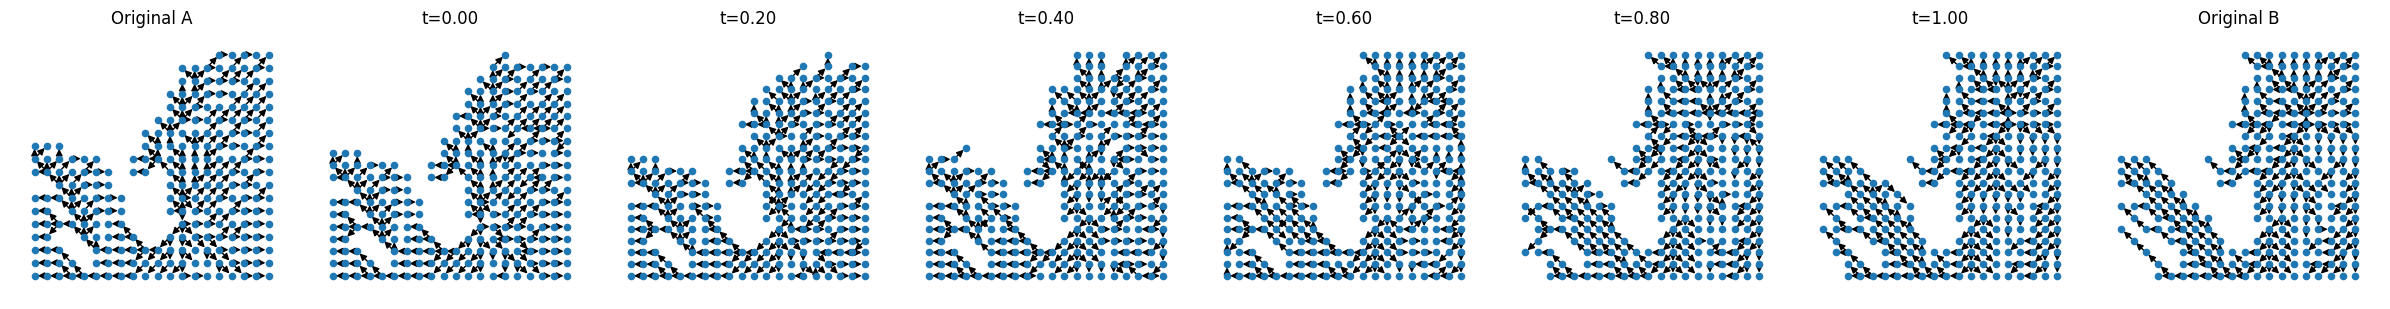

In [43]:
interpolate_two_graphs_and_plot(model, loader_, template=dataset.template, n_steps=6, tau_edge=0.1, sample=False, device=device)

## VS no post-processing

In [8]:
import torch, networkx as nx
from tqdm import tqdm

# ---------- helper: MST with uniform edge weights (weight=1) ----------
@torch.no_grad()
def _pred_tree_uniform_mst_from_logits(
    edge_logits_u,        # [E_u] tensor (logits for feasible undirected pairs)
    ign_logits,           # [N]   tensor (ignition logits over slots)
    template,             # has .undir_src, .undir_dst, .H, .W, .Nmax
    tau_edge: float = 0.5
):
    """
    1) Threshold undirected edge probs (sigmoid >= tau_edge).
    2) Build an undirected graph with all kept edges weight=1.
    3) Restrict to the component containing the predicted ignition.
    4) Compute an MST (all weights equal).
    5) Orient edges away from ignition (directed arborescence).
    """
    p_u = torch.sigmoid(edge_logits_u).detach().cpu()  # [E_u]
    keep = (p_u >= tau_edge).nonzero(as_tuple=False).view(-1)

    # Undirected candidate pairs
    s_all = template.undir_src
    t_all = template.undir_dst
    if torch.is_tensor(s_all):
        s_all = s_all.cpu().tolist()
        t_all = t_all.cpu().tolist()

    # Build undirected graph with kept edges (uniform weights)
    G_u = nx.Graph()
    N = int(template.Nmax)
    G_u.add_nodes_from(range(N))
    for idx in keep.tolist():
        s, t = int(s_all[idx]), int(t_all[idx])
        if s != t:
            G_u.add_edge(s, t, weight=1.0)

    # Predicted ignition (top-1)
    ign = int(torch.argmax(ign_logits).item())

    # Restrict to component containing ignition
    if ign in G_u and G_u.number_of_nodes() > 0 and G_u.degree(ign) > 0:
        comp_nodes = nx.node_connected_component(G_u, ign)
        G_u = G_u.subgraph(comp_nodes).copy()
    else:
        G_trivial = nx.DiGraph()
        G_trivial.add_node(ign)
        return G_trivial, ign

    # Maximum spanning tree with uniform weights
    T_u = nx.maximum_spanning_tree(G_u, weight="weight")

    # Orient via BFS from ignition
    return nx.bfs_tree(T_u, source=ign), ign


def _pred_tree_from_logits_by_mst_mode(
    edge_logits_u,
    ign_logits,
    template,
    tau_edge: float,
    mst_mode: str,
):
    if mst_mode == "weighted":
        return _pred_tree_from_logits(edge_logits_u, ign_logits, template, tau_edge=tau_edge)
    if mst_mode == "uniform":
        return _pred_tree_uniform_mst_from_logits(edge_logits_u, ign_logits, template, tau_edge=tau_edge)
    raise ValueError(f"Unknown mst_mode: {mst_mode}")


In [9]:
best_tau_weighted, metrics_by_tau_weighted = tune_tau_edge_for_tree_f1(
    model, val_loader, dataset.template, device, decode_fn=_pred_tree_from_logits
)
best_tau_uniform, metrics_by_tau_uniform = tune_tau_edge_for_tree_f1(
    model, val_loader, dataset.template, device, decode_fn=_pred_tree_uniform_mst_from_logits
)


100%|██████████| 18/18 [03:50<00:00, 12.78s/it]


In [20]:
best_tau_weighted, best_tau_uniform


(0.1, 0.4)

In [21]:
plot_tau_edge_curve(
    metrics_by_tau_weighted,
    save_path="./Threshold_curve_mst_weighted_graph_vae.png",
    title="τ_edge sweep (weighted MST tree F1)",
)
plot_tau_edge_curve(
    metrics_by_tau_uniform,
    save_path="./Threshold_curve_mst_uniform_graph_vae.png",
    title="τ_edge sweep (uniform MST tree F1)",
)


In [22]:
import numpy as np

def extract_curves_and_best(metrics_by_tau):
    taus = sorted(metrics_by_tau.keys())
    prec = [metrics_by_tau[t]["precision"] for t in taus]
    rec  = [metrics_by_tau[t]["recall"]    for t in taus]
    f1   = [metrics_by_tau[t]["f1"]        for t in taus]

    # best by F1
    best_idx = int(np.argmax(f1))
    best = {
        "tau": taus[best_idx],
        "precision": prec[best_idx],
        "recall": rec[best_idx],
        "f1": f1[best_idx],
    }
    return taus, prec, rec, f1, best


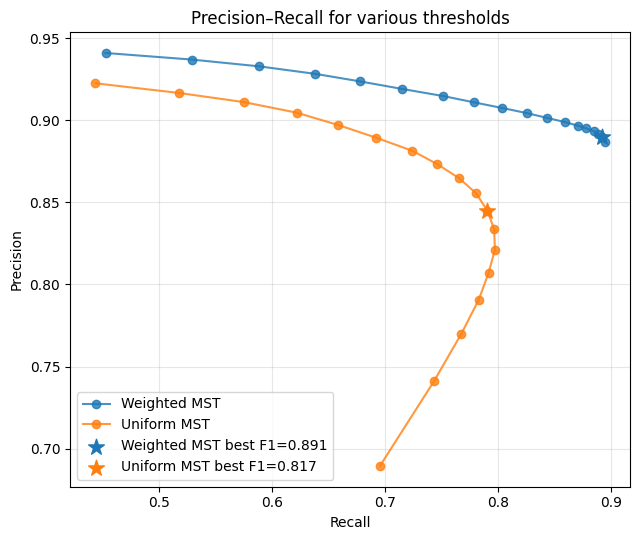

In [23]:
import matplotlib.pyplot as plt

# compare PR curves for weighted vs uniform MST

taus_w, prec_w, rec_w, f1_w, best_w = extract_curves_and_best(metrics_by_tau_weighted)
taus_u, prec_u, rec_u, f1_u, best_u = extract_curves_and_best(metrics_by_tau_uniform)

plt.figure(figsize=(6.5, 5.5))

# curves
plt.plot(rec_w, prec_w, "o-", label="Weighted MST", alpha=0.8)
plt.plot(rec_u, prec_u, "o-", label="Uniform MST", alpha=0.8)

# stars at best F1
plt.scatter(
    best_w["recall"], best_w["precision"],
    s=140, marker="*", zorder=5,
    label=f"Weighted MST best F1={best_w['f1']:.3f}"
)
plt.scatter(
    best_u["recall"], best_u["precision"],
    s=140, marker="*", zorder=5,
    label=f"Uniform MST best F1={best_u['f1']:.3f}"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall for various thresholds")
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("post_pr_compare.png")


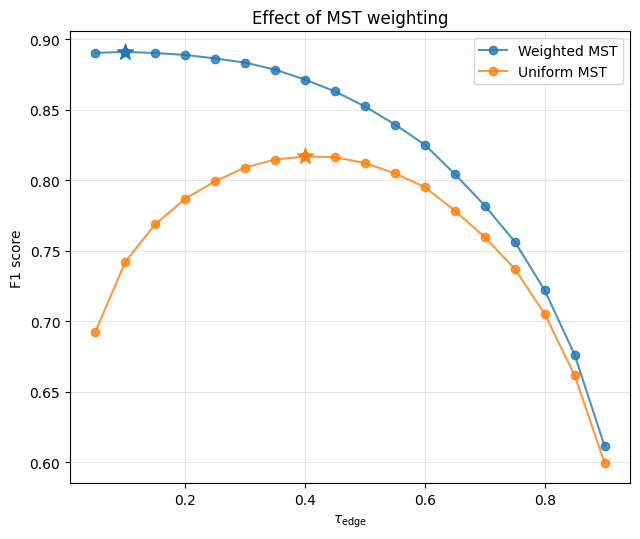

In [24]:
plt.figure(figsize=(6.5, 5.5))

plt.plot(taus_w, f1_w, "o-", label="Weighted MST", alpha=0.8)
plt.plot(taus_u, f1_u, "o-", label="Uniform MST", alpha=0.8)

# stars at best τ
plt.scatter(
    best_w["tau"], best_w["f1"],
    s=140, marker="*", zorder=5
)
plt.scatter(
    best_u["tau"], best_u["f1"],
    s=140, marker="*", zorder=5
)

plt.xlabel(r"$\tau_{\mathrm{edge}}$")
plt.ylabel("F1 score")
plt.title("Effect of MST weighting")
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("post_f1_compare.png")


In [25]:
def confusion_counts(G_pred: nx.DiGraph, G_true: nx.DiGraph):
    e_pred = set(G_pred.edges())
    e_true = set(G_true.edges())

    tp = len(e_pred & e_true)
    fp = len(e_pred - e_true)
    fn = len(e_true - e_pred)

    # TN is not well-defined over "all possible edges",
    # but for accuracy we define:
    # acc = TP / |E_true|   (tree setting)
    return tp, fp, fn


In [26]:
@torch.no_grad()
def collect_graph_metrics(
    model,
    loader,
    template,
    device,
    tau_edge: float,
    mst_mode: str,
):
    model.eval()
    metrics = []

    for batch in loader:
        batch = batch.to(device)
        (edge_logits_u_B, ign_logits_B), _, _ = model(
            batch.x, batch.edge_index_enc, batch
        )
        B = edge_logits_u_B.size(0)

        for b in range(B):
            G_true = _gt_tree_from_batch(batch, template, b=b)
            G_pred, _ = _pred_tree_from_logits_by_mst_mode(
                edge_logits_u=edge_logits_u_B[b],
                ign_logits=ign_logits_B[b],
                template=template,
                tau_edge=tau_edge,
                mst_mode=mst_mode,
            )

            tp, fp, fn = confusion_counts(G_pred, G_true)
            denom_true = max(1, len(G_true.edges()))

            prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1   = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0
            acc  = tp / denom_true

            metrics.append({
                "precision": prec,
                "recall": rec,
                "f1": f1,
                "accuracy": acc,
            })

    return metrics


In [27]:
import numpy as np

def bootstrap_ci(values, n_boot=2000, ci=95):
    vals = np.asarray(values)
    boots = []
    n = len(vals)

    for _ in range(n_boot):
        sample = np.random.choice(vals, size=n, replace=True)
        boots.append(sample.mean())

    lo = np.percentile(boots, (100 - ci) / 2)
    hi = np.percentile(boots, 100 - (100 - ci) / 2)
    return vals.mean(), lo, hi


In [28]:
def graph_metrics_with_ci(
    model,
    loader,
    template,
    device,
    tau_edge,
    mst_mode: str,
    n_boot=2000,
):
    metrics = collect_graph_metrics(
        model, loader, template, device, tau_edge, mst_mode=mst_mode
    )

    out = {}
    for k in ["precision", "recall", "f1", "accuracy"]:
        mean, lo, hi = bootstrap_ci([m[k] for m in metrics], n_boot=n_boot)
        out[k] = {
            "mean": mean,
            "ci_low": lo,
            "ci_high": hi,
        }
    return out


In [29]:
ci_results = {
    "weighted_mst": graph_metrics_with_ci(
        model=model,
        loader=test_loader,
        template=model.template,
        device=device,
        tau_edge=best_tau_weighted,
        mst_mode="weighted",
    ),
    "uniform_mst": graph_metrics_with_ci(
        model=model,
        loader=test_loader,
        template=model.template,
        device=device,
        tau_edge=best_tau_uniform,
        mst_mode="uniform",
    ),
}

for mode, stats in ci_results.items():
    print(f"{mode}:")
    for k, v in stats.items():
        print(
            f"  {k:10s}: {v['mean']:.3f} "
            f"[{v['ci_low']:.3f}, {v['ci_high']:.3f}]"
        )


weighted_mst:
  precision : 0.892 [0.890, 0.895]
  recall    : 0.900 [0.897, 0.903]
  f1        : 0.895 [0.893, 0.898]
  accuracy  : 0.900 [0.897, 0.903]
uniform_mst:
  precision : 0.852 [0.849, 0.856]
  recall    : 0.806 [0.801, 0.812]
  f1        : 0.821 [0.816, 0.826]
  accuracy  : 0.806 [0.801, 0.812]
